# Near Equatorial Remote Sensing Satellite (NERSS)

Data Source: celestrak.org <br> 
- resource.txt
- planet.txt
- spire.txt <br>

downloaded at 16/06/2023

remove:
- GAOFEN 4 (GEO)
- SKYSAT-A, SKYSAT-B, SKYSAT-C1, SKYSAT-C4, SKYSAT-C5, SKYSAT-C2, SKYSAT-C3, SKYSAT-C11, SKYSAT-C10, SKYSAT-C9, SKYSAT-C*, SKYSAT-C7, SKYSAT-C6 from resource.txt, due to duplicate with planet.txt

In [2]:
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import pandas as pd

f = open('gp_3.txt') #gp_3 is combination of resource, planet, and spire, excluding some satellites
l = f.readlines()
f.close()
# sma = np.zeros(len(l))
# r_day = np.zeros(len(l))
# epoch_2000 = np.zeros(len(l))
# nama_sat = [None]*len(l)
# inklinasi = np.zeros(len(l))
# omega_p = np.zeros(len(l))

mu = 3.986004418*(10**14)/((2*np.pi)**2)
J2 = 0.108262668e-2
ae = 6.3781363e6

calculate the nodal precession,

$ \omega_{p} = -\frac{3}{2}\  \frac{R_{e}^{2}}{{a(1-e^2)}^2} J_{2} \omega cos(i) $

where <br>
$ \omega_{p} $ is nodal precession in rad/s<br>
$ R_{e} $ is earth equatorial radius in km <br>
$ a $ is semi-major axis in km <br>
$ e $ is eccentricity
$ \omega $ is angulaver velocity of the satellite's motion in rad/s <br>
$ i $ is incliation in rad

The eccintricity is assumed to be zero (?) <br>
1 rev/day = 7.27221e-5 rad/s <br>
1 rad/s = 4950355.3499303 deg/day <br>

Classify the satellite into SSO and non-SSO based on the nodal precession.
The nodal precession for SSO is aproximately 0.9856 deg/day.
A satellite is calssified as a SSO if the nodal precession is +- 0.12 from 0.9856 deg/day.

In [6]:
df_SSO = pd.DataFrame([], columns=['Name', 'ID', 'Altitude', 'Inclination', 'Nodal Prec'])
df_nonSSO = pd.DataFrame([], columns=['Name', 'ID', 'Altitude', 'Inclination', 'Nodal Prec'])

i = 0
while i < len(l)-2:
    nama_sat = l[i].strip()
    i = i+1
    sat_id = l[i][2:7]
    eyear=int(l[i][18:20])+2000
    eday=float(l[i][20:32])
    epoch=datetime.datetime(eyear,1,1,0,0,0)+datetime.timedelta(days=eday)
    d=epoch-datetime.datetime(2000,1,1,0,0,0)
    epoch_2000=d.days+d.seconds/86400
    i = i+1
    meanmo=float(l[i][52:63])
    period=24/meanmo
    sma=((period*3600)**2*mu)**(1/3)
    r_day=meanmo-int(meanmo); 
    inklinasi=float(l[i][9:16])
    omega_p=-3/2 * ae**2/sma**2 * J2*meanmo*7.27221e-5*np.cos(inklinasi*np.deg2rad(1)) * 4950355.3499303
    d = {'Name':nama_sat, 'ID':sat_id, 'Altitude':sma/1000-6378, 'Inclination':inklinasi, 'Nodal Prec':omega_p}
    if abs(omega_p-0.9856)>0.12:
        df_nonSSO = pd.concat([df_nonSSO, pd.DataFrame(data=d, index=[df_nonSSO.shape[0]])])
    else:
        df_SSO = pd.concat([df_SSO, pd.DataFrame(data=d, index=[df_SSO.shape[0]])])
    i = i+1

[Text(0.5, 0, 'Altitude (km)'), Text(0, 0.5, 'Inclination $(^{o})$')]

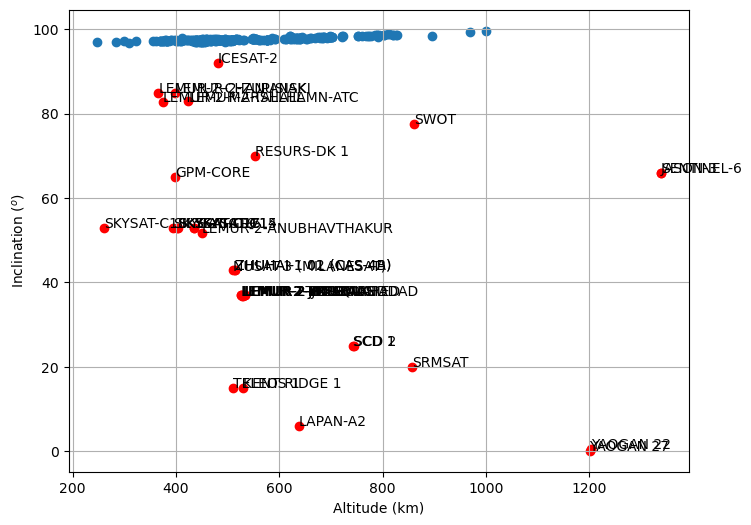

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(df_SSO['Altitude'], df_SSO['Inclination'])
ax.scatter(df_nonSSO['Altitude'], df_nonSSO['Inclination'], color='red')
[ax.text(df_nonSSO['Altitude'][i], df_nonSSO['Inclination'][i], df_nonSSO['Name'][i]) for i in range(df_nonSSO.shape[0])]
ax.grid(visible=True)
ax.set(xlabel='Altitude (km)', ylabel='Inclination $(^{o})$')

The figure shows 454 satellites, 418 shown in blue are SSO, and 36 shown in red are non-SSO.
Here are a list of the non-SSO satellites:

In [8]:
print(df_nonSSO)

                     Name     ID     Altitude  Inclination  Nodal Prec
0                   SCD 1  22490   742.370918      24.9679   -6.144592
1                   SCD 2  25504   744.020211      24.9968   -6.138170
2             RESURS-DK 1  29228   552.073059      69.9360   -2.556601
3                  SRMSAT  37841   856.425196      19.9707   -6.025812
4                GPM-CORE  39574   397.691779      64.9955   -3.408370
5               YAOGAN 22  40275  1202.250348       0.6129   -5.444348
6               YAOGAN 27  40878  1200.197246       0.0940   -5.449816
7                LAPAN-A2  40931   638.198181       5.9993   -7.097764
8            KENT RIDGE 1  41167   530.248185      14.9809   -7.278769
9                TELEOS 1  41169   509.508975      14.9817   -7.355741
10                JASON-3  41240  1337.872592      66.0415   -2.077885
11   ZHUHAI-1 02 (CAS-4B)  42759   513.924099      43.0137   -5.555230
12    NUSAT-3 (MILANESAT)  42760   510.114285      43.0102   -5.566309
13   Z

Calculate the local time of each satellite.
The local time is calculated not only when crossing the equator but at any point in the orbit to see the variance as a function of satellite location (especially latitude). To see the local time variance over time, each satellite calculates the local time in 1 year, 1 January 2022 to 1 January 2023 with 1 minute interval. For each time, respective TLE must be used, which can be downloaded from space-track.org.

The local time is calculated as follows,

$ LT = {RA}_{sun} - {RA}_{sat} + 12 $ <br>
where, <br>
$LT$ is local time of the satellite <br>
${RA}_{sun}$ is right ascencion of the Sun in hour <br>
${RA}_{sat}$ is right ascension of the satellite in hour <br>

In [2]:
%%time

from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import datetime as dt
from skyfield.api import EarthSatellite, load, wgs84, Topos

st = SpaceTrackClient('******', '******')
drange = op.inclusive_range(dt.datetime(2022, 1, 1), dt.datetime(2023, 1, 1)) #1 tahun TLE
ephem = load('de421.bsp')
sun = ephem['Sun']
earth = ephem['Earth']

ts = load.timescale()
# t = ts.utc(2022, 1, 1, 0, 0, range(0, 3*86400,1)) #cuma 3 hari
t = ts.utc(2022, 1, 1, 0, range(0, 3*1440,1), 0) #cuma 3 hari

# i = 0
df = pd.DataFrame([])
n = np.zeros([df_SSO.shape[0], 1440])
for i in range(df_SSO.shape[0]):
# for i in range(5):
    print(df_SSO['Name'][i])
    tle = st.tle(norad_cat_id=df_SSO['ID'][i], orderby='epoch asc', epoch=drange, format='tle')
    if tle != '':
        tle_ = list(tle.split('\n'))
        df_tle = pd.DataFrame([], columns=['epoch_t', 'L1', 'L2'])
        for k in range(len(tle_)-1):
            if tle_[k][0] == '1':
                L1 = tle_[k] #ambil 1 TLE
                L2 = tle_[k+1]

                id_ = tle_[k][2:7]
                eyear = int(tle_[k][18:20])+2000
                eday = float(tle_[k][20:32])
                epoch = ts.utc(float(eyear), 1, float(eday), 0, 0, 0)
                d = {'epoch_t' : epoch,
                     'L1' : L1,
                     'L2' : L2}
                # print(d)
                df_tle = pd.concat([df_tle, pd.DataFrame(data=d, index=[df_tle.shape[0]])])
        # print(df_tle.iloc[0])

        i_tle = 0
        # df = pd.DataFrame([], columns=['LT'])
        t_now = list([])
        # ep = np.array(epoch)
        ep = np.array(df_tle['epoch_t'])
        df_LT = pd.DataFrame([], columns=['LT'])
        ty = t[t.tt - ep[0].tt > -1] #ambil hanya t setelah epoch pertama - 1 hari, yg diasumsikan sebagai waktu mencapai orbit
        # print(ty.shape[0])
        # print(t[0] - ep[0])
        if ty.shape[0] > 0:
            for j in range(ty.shape[0]):
                t_ = np.array(ty[j])
                differences = np.abs(ep[:, np.newaxis] - t_)
                i_tle_now = differences.argmin(axis=0)
                if i_tle_now == i_tle:
                    t_now.append(ty[j])
                else:
                    L1 = str(df_tle['L1'][i_tle_now[0]])
                    L2 = str(df_tle['L2'][i_tle_now[0]])
                    sat =  EarthSatellite(L1, L2, 'SSO', ts)

                    tx = ts.utc(t_now[0].utc.year,
                                t_now[0].utc.month,
                                t_now[0].utc.day,
                                t_now[0].utc.hour,
                                t_now[0].utc.minute,
                                range(int(t_now[0].utc.second), int((t_now[-1] - t_now[0])*86400), 1))

                    geocentric = sat.at(tx)
                    r = wgs84.geographic_position_of(geocentric)
                    R_GCRS = geocentric.position.km
                    ra_sat = np.arctan2(R_GCRS[1,], R_GCRS[0,])*np.rad2deg(1)/15
                    ra_sun, de_sun, d_sun = (earth).at(tx).observe(sun).apparent().radec()
                    ra_sun_h = ra_sun.hours
                    LT_sat = ra_sat - ra_sun_h + 12
                    LT_sat[LT_sat<0] = LT_sat[LT_sat<0] + 24
                    d = {'LT' : LT_sat}
                    df_LT = pd.concat([df_LT, pd.DataFrame(data=d)], ignore_index=True)

                    # print(t_now[0], t_now[-1], ep[i_tle])
                    i_tle = i_tle_now
                    # print(i, i_tle)
                    # print(len(t_now))
                    t_now = list()
                    t_now.append(ty[j])
                    # print(len(t_now))
            # print(t_now[0], t_now[-1], ep[i_tle])
            # print(len(t_now))
            L1 = str(df_tle['L1'][i_tle_now[0]])
            L2 = str(df_tle['L2'][i_tle_now[0]])
            sat =  EarthSatellite(L1, L2, 'SSO', ts)

            tx = ts.utc(t_now[0].utc.year,
                        t_now[0].utc.month,
                        t_now[0].utc.day,
                        t_now[0].utc.hour,
                        t_now[0].utc.minute,
                        range(int(t_now[0].utc.second), int((t_now[-1] - t_now[0])*86400), 1))

            geocentric = sat.at(tx)
            r = wgs84.geographic_position_of(geocentric)
            R_GCRS = geocentric.position.km
            ra_sat = np.arctan2(R_GCRS[1,], R_GCRS[0,])*np.rad2deg(1)/15
            ra_sun, de_sun, d_sun = (earth).at(tx).observe(sun).apparent().radec()
            ra_sun_h = ra_sun.hours
            LT_sat = ra_sat - ra_sun_h + 12
            LT_sat[LT_sat<0] = LT_sat[LT_sat<0] + 24
            d = {'LT' : LT_sat}
            df_LT = pd.concat([df_LT, pd.DataFrame(data=d)], ignore_index=True)

            LT_n, LT_bins = np.histogram(df_LT['LT'], bins=1440, range=(0,24))
            n[i,] = np.atleast_2d(LT_n)
    df = pd.DataFrame(n)
    H = ["%02d:%02d" % (divmod(minutes, 60)) for minutes in np.arange(0, 1440, 1)]
    df.index = df_SSO['Name']
    df.columns = H
    df.to_csv(df_SSO['Name'][i] + '.LT')

CPU times: total: 328 ms
Wall time: 436 ms


The local time distribution of each satellite are calculated. The data is sorted ascending by the mode of the local lime. Here are example of first 16 satellite's local time distribution.

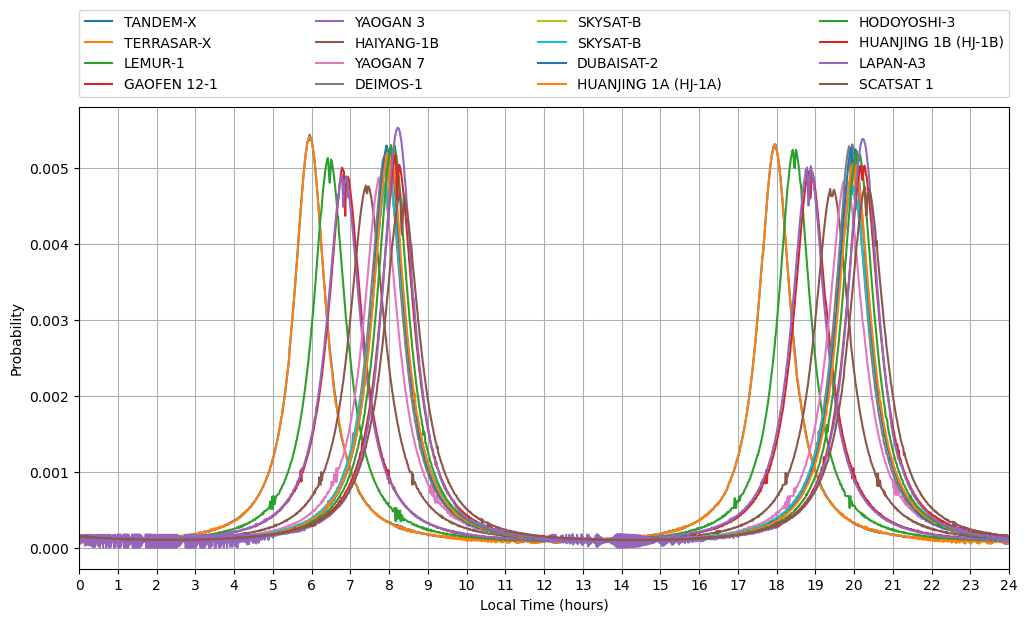

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('3days_allsat.LT', index_col=0)
df['sum'] = df.sum(axis=1)
df.max(axis=1)
df = df.loc[:,:].div(df['sum'], axis=0)
df = df.drop(columns='sum')
df['Id Max'] = df[df.columns[range(360, 1080)]].idxmax(axis=1)
df = df.sort_values(by='Id Max')
df = df.drop(columns='Id Max')

fig, ax = plt.subplots(figsize=(12, 6))
x_ = [i/1440*24 for i in range(0, 1440)]
[ax.plot(x_, df.iloc[i], label=df.index[i]) for i in range(16)]
ax.grid(visible=True)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=4, loc='lower left', mode="expand", borderaxespad=0.)
ax.set(xlabel='Local Time (hours)', ylabel='Probability')
ax.set_xlim([0, 24])
ax.locator_params(axis='x', nbins=24)

plot heatmap,
itung std, mode, median, mean, masing2 satelit, plot
kesimpulan: 1 nilai (mode, median, mean) sebagai acuan LT tengah +/- (1,2,3)*std atau persentil

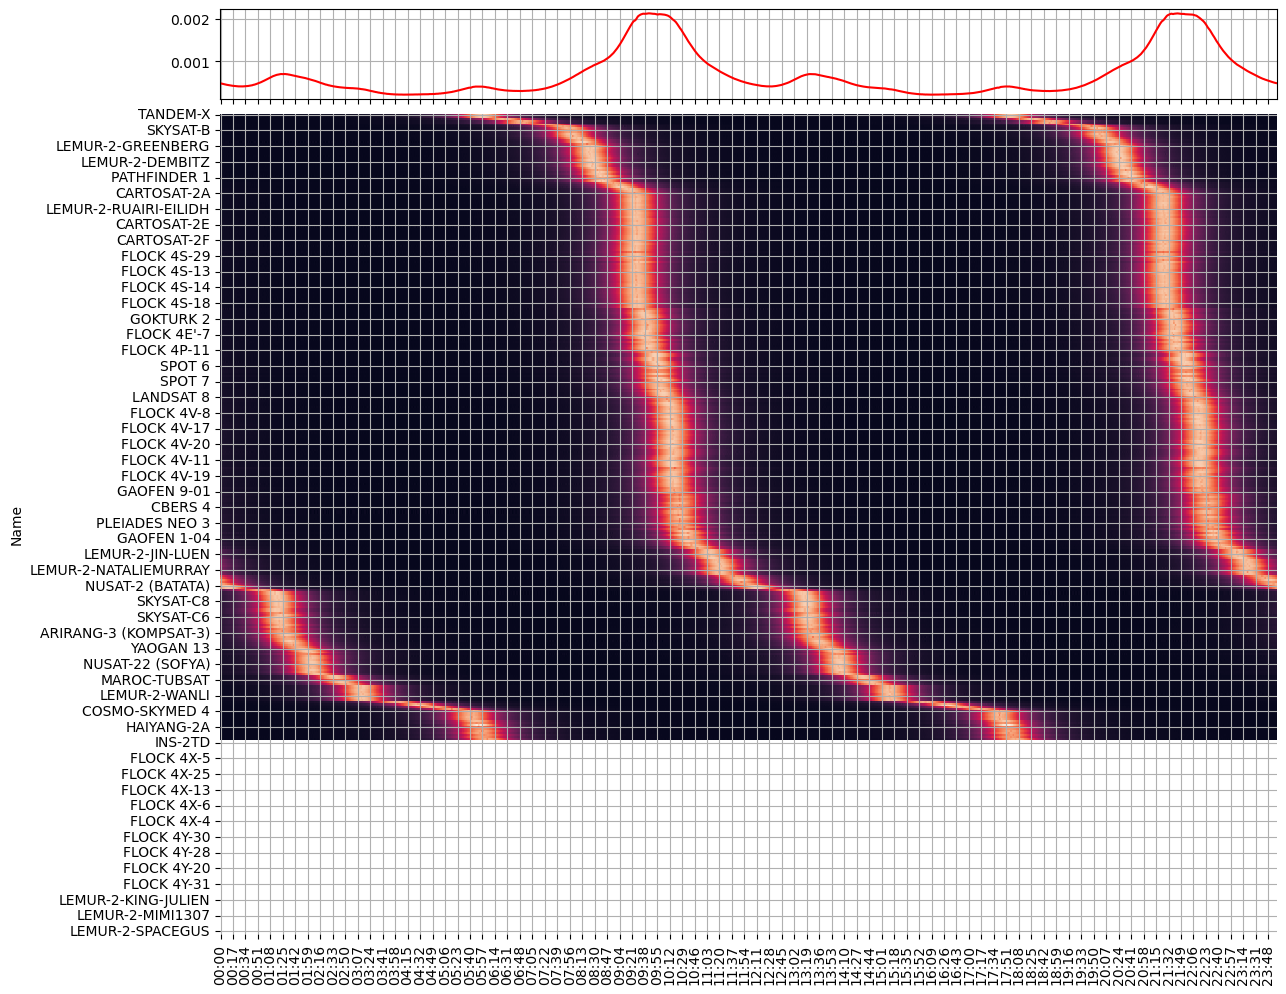

In [2]:
import seaborn as sns

# fig, ax = plt.subplots(2, 1, figsize=(8, 16), sharex=True)
fig, ax = plt.subplot_mosaic([['atas'], ['bawah'], ['bawah'], ['bawah'], ['bawah'], ['bawah'], ['bawah'], ['bawah'], ['bawah']], figsize=(16, 12), constrained_layout=True, sharex=True)
sns.heatmap(ax=ax['bawah'], data=df, cbar=0)
pdf = df.sum(axis=0)/sum(df.sum(axis=0))
ax['atas'].plot(df.columns, pdf, color='red')
ax['bawah'].grid(True)
ax['atas'].grid(True)
fig.tight_layout()

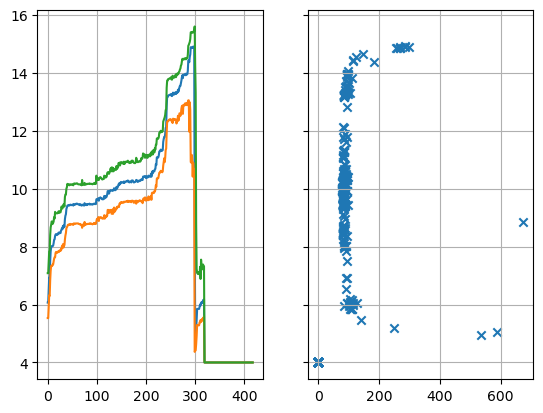

In [73]:
import numpy as np

x_4to16 = [i/1440*24 for i in range(240, 960)]
# df.sum(axis=1)
pdf_4to16 = df[df.columns[range(240, 960)]].div(df[df.columns[range(240, 960)]].sum(axis=1), axis=0)
cdf_4to16 = np.cumsum(pdf_4to16, axis=1)
    
median_idx = [np.argmax(cdf_4to16.iloc[i] >= 0.5) for i in range(pdf_4to16.shape[0])]
median = [x_4to16[median_idx[i]] for i in range(pdf_4to16.shape[0])]
lower_idx = [np.argmax(cdf_4to16.iloc[i] >= 0.2) for i in range(pdf_4to16.shape[0])]
lower = [x_4to16[lower_idx[i]] for i in range(pdf_4to16.shape[0])]
upper_idx = [np.argmax(cdf_4to16.iloc[i] >= 0.8) for i in range(pdf_4to16.shape[0])]
upper = [x_4to16[upper_idx[i]] for i in range(pdf_4to16.shape[0])]
lower2upper = (np.array(upper) - np.array(lower)) * 60

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(median)
ax[0].plot(lower)
ax[0].plot(upper)
ax[1].scatter(lower2upper, median, marker='x')
ax[0].grid(visible=True)
ax[1].grid(visible=True)

8.764473684210527 74.30143540669856 3.2146740573544688 66.00025407988566 13.266666666666667 96.99999999999994


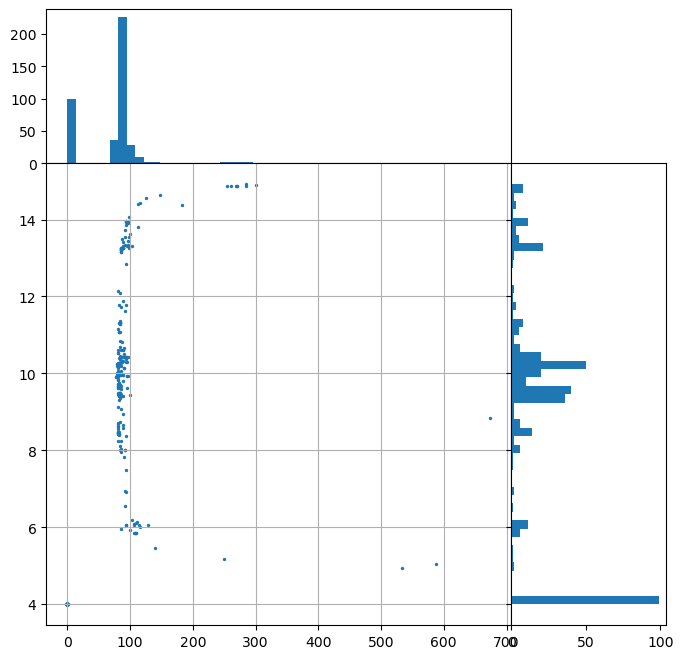

In [80]:
def scatter_hist(data_x, data_y):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [3, 1], 'height_ratios':[1, 3]})
    ax[1][0].scatter(data_x, data_y, s=2)
    ax[1][0].grid(visible=True)
    ax[1][1].hist(data_y, 50, orientation='horizontal')
    ax[1][1].tick_params(labelleft=False)
    ax[0][0].hist(data_x, 50)
    ax[0][0].tick_params(labelbottom=False)
    ax[0][1].remove()
    plt.subplots_adjust(wspace=0, hspace=0)
    
scatter_hist(lower2upper, median)
print(np.mean(median), np.mean(lower2upper), np.std(median), np.std(lower2upper), np.percentile(median, 90), np.percentile(lower2upper, 90))

buat distribusi LT SSO untuk tiap variasi minmax latitud